In [1]:
# Project library Imports
from lc_tutorials.appearance.notebook import apply_custom_styles, cprint
from lc_tutorials.appearance.displays import display_tavily_search_results
from lc_tutorials.functionality.utils import setup_environment

# Standard library imports
import os
import sys
import json
import time
import random
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import display, HTML, Markdown, Image, Javascript

# Third-party imports
from dotenv import load_dotenv, find_dotenv
from colorama import Back, Fore, Style, init
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph Imports
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain Imports
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI


custom_style="""
<style>
/* General styles */
.result-container {
    max-width: 90%;
    margin: 1em 0;
}

/* Card Styling */
.result-card {
    background-color: #f8f9fa;
    border-left: 4px solid #05bfa5;
    border-radius: 8px;
    margin-bottom: 1em;
    overflow: hidden;
}

/* Header Styling */
.result-header {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-weight: bold;
    font-size: 1.05em;
    color: #2c3e50;
    background-color: #e9ecef;
    cursor: pointer;
}

.result-header:hover {
    background-color: #dfe4ea;
}

/* Content Styling */
.result-content {
    display: none;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-size: 0.95em;
    color: #34495e;
}

/* Link Styling */
.result-link {
    text-decoration: none;
    color: #3498db;
    font-weight: bold;
}
</style>

<script>
// JavaScript function to toggle visibility of the result content and icon
function toggleContent(id, iconId) {
    var content = document.getElementById(id);
    var icon = document.getElementById(iconId);
    if (content.style.display === "none" || content.style.display === "") {
        content.style.display = "block";
        icon.innerHTML = "&#9660;";  // Change to down-facing arrow
    } else {
        content.style.display = "none";
        icon.innerHTML = "&#9654;";  // Change to right-facing arrow
    }
}
</script>
"""
apply_custom_styles(use_base=True, custom_style=custom_style)
setup_environment()

def is_message_a_tool_call(message):
    return hasattr(message, "tool_calls") and len(message.tool_calls) > 0


✅ Environment Variables Loaded Successfully



<div class="h1-container">

# 🚀 Quick Start <sub> ··· continued!</sub>

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

<div class="feature-list">

- 🧠 Answer common questions w/ a basic chatbot
- 🔍 Answer common questions by searching the web
- 💾 Maintain conversation state across calls
- <span style="color: teal; font-weight: bold;">🔄 Route complex queries to a human for review [THIS NOTEBOOK]</span>
- ⚙️ Use custom state to control its behavior
- 🌳 Rewind and explore alternative conversation paths

</div>

<br>

Previously we built a basic chatbot, and one that could operate tools and persist memory across multiple turns of conversation... we will now enhance our ChatBot with <b>the ability for human intervention</b>. 

</div>

<div class="h2-container">

## Part 4: Adding Human-in-the-Loop (HITL) Functionality

While our chatbot can now remember previous interactions, agents can sometimes be unreliable or require human oversight. For critical actions, integrating a human-in-the-loop mechanism ensures tasks are completed successfully and as intended.

<div class="notice-block">
<h4 style="margin-top: 0; color: #f39c12;">Why HITL Matters?</h4>
<p>
    LangGraph introduces robust HITL workflows through features like <code class="code-mention">interrupt_before</code>. By configuring the graph to break at specific nodes, developers can pause execution and request human input or approval before proceeding. This empowers you to maintain control over sensitive or complex operations, combining automation with human judgment.
</p>
</div>

<div class="note-block">
<h4 class="note-title">Why HITL Matters</h4>
<p>
    - Prevent errors in critical tasks by validating actions through human review.<br>
    - Enable seamless collaboration between automation and human oversight.<br>
    - Ensure transparency and accountability in decision-making processes.
</p>
</div>

</div>


<div class="h3-container">

### 💭 Recall What We Did Previously...

<br>



In [8]:
class State(TypedDict):
    """Defines the state schema for the chatbot graph.
    
    Attributes:
        messages (Annotated[list, add_messages]): List of conversation messages.
            Uses add_messages reducer to append rather than overwrite messages.
    """
    messages: Annotated[list, add_messages]
    

def initialize_graph():
    """Initialize the StateGraph with the defined State schema.
    
    Returns:
        StateGraph: Configured graph builder instance
    """
    return StateGraph(State)


def chatbot(state: State) -> dict:
    """Process the current state and generate a response using the language model.
    
    Args:
        state (State): Current state containing conversation messages
        
    Returns:
        dict: Updated state with new message appended
    """
    return {"messages": [llm.invoke(state["messages"])]}

# Initialize persistent memory
memory = MemorySaver()

# Initialize the graph builder
graph_builder = initialize_graph()

# Initialize our tool
tool = TavilySearchResults(max_results=2)

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o")
llm = llm.bind_tools([tool,])

# Add the chatbot and tool nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# Add the conditional edge using the prebuilt `tools_condition`
graph_builder.add_conditional_edges("chatbot", tools_condition,)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

<div class="h3-container">

### Managing Interrupts: Before vs. After Execution

Next, we need to compile the graph with specific instructions to pause execution at designated points. The key feature demonstrated here is the use of <code class="code-mention">interrupt_before</code> and <code class="code-mention">interrupt_after</code>, which allow for fine-grained control over the workflow's execution flow:

<br>

**HOW DOES THIS ACTUALLY WORK?**

---

<p>1. <b>Graph Compilation:</b> The graph is being compiled with a <code class="code-mention">checkpointer</code> to enable memory persistence. This ensures the graph can retain its state across multiple interactions.</p>

<p>2. <b>Interrupts Defined:</b>
   - <code class="code-mention">interrupt_before=["tools"]</code>: This configuration pauses execution <b>before</b> the specified node (<code class="code-mention">tools</code>) runs, allowing for pre-execution validation or human intervention.
   - <code class="code-mention">interrupt_after=["tools"]</code> (commented): Alternatively, this would pause execution <b>after</b> the node completes, enabling post-execution review or logging.</p>

</div>

<br>


🧜‍♀️ Mermaid Chart for Our Graph



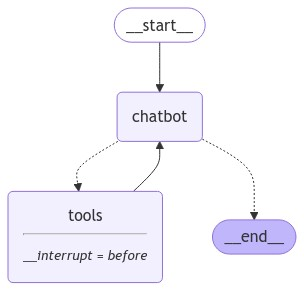

In [9]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],  # Pauses before executing the 'tools' node
    # interrupt_after=["tools"]  # Note: can also interrupt __after__ tools, if desired.
)

cprint("\n🧜‍♀️ Mermaid Chart for Our Graph\n", fg_color="blue", bold=True)
display(Image(graph.get_graph().draw_mermaid_png()))

<div class="h3-container">

### 🤖 Running Your Chatbot

Let's run our bot...<br><b>We can now ask the bot a questions and it will stop prior to running any tools!</b>

</div>


In [10]:
config_thread_id: int | str = 1
EXIT_COMMANDS = {"quit", "exit", "q", "bye", "goodbye"}
message_history = []
_config = {"configurable": {"thread_id": str(int(config_thread_id))}}

# Display welcome banner
cprint("\n"+"="*50, fg_color="blue", bold=True)
cprint("🦜 Welcome to LangGraph Chat!", fg_color="yellow", bold=True)
cprint("Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation", fg_color="white", bold=True)
cprint("="*50+"\n", fg_color="blue", bold=True)

# Get user input with styled prompt
user_input = input("\nUser Input: ")

# Process user message through graph
message_history.append(("user", user_input))

for event in graph.stream({"messages": message_history}, _config, stream_mode="values"):
    # Define what we are working with here
    last_message = event["messages"][-1]
    response = last_message.content

    # Check which flavour of message it is...
    if is_message_a_tool_call(last_message):
        response_type = "tool_calls"
        cprint(f"\n🦾 LLM has decided to use the tool named '{last_message.tool_calls[0]["name"]}'\n", fg_color="blue", bold=True)
    elif hasattr(last_message, "tool_call_id"):
        display_tavily_search_results(json.loads(response))
    else:
        if last_message.type=="human":
            cprint(text=response, prefix_text="\nUser: ", fg_color="blue", bold_prefix=True)
            message_history.append(("human", response))
        elif last_message.type=="ai":
            cprint(text=response, prefix_text="\nAssistant: ", fg_color="green", bold_prefix=True)
            message_history.append(("assistant", response))

cprint("\nThe cell is done executing!\n", "red", bold=True)


🦜 Welcome to LangGraph Chat!
Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation




User Input:  Who is Darien Schettler



User: Who is Darien Schettler

🦾 LLM has decided to use the tool named 'tavily_search_results_json'


The cell is done executing!



<div class="h3-container">

### 🍿 Running Your Chatbot (INTERMISSION)

<p>Let's inspect the graph state to confirm it worked.</p>

<p>Notice that unlike last time, the <code class="code-mention">"next"</code> node is set to <code class="code-mention">'tools'</code>. We've interrupted here! Let's check the tool invocation too.</p>

<p>You should see a reasonable looking query Nothing to filter here. The simplest thing the human can do is just let the graph continue executing.</p>

<p>Let's do that as the final step and continue the rest of the conversational turn. Passing in <code class="code-mention">None</code> will just let the graph continue where it left off, without adding anything new to the state.</p>

</div>


In [19]:
cprint("\n\nGRAPH STATE - SNAPSHOT\n", fg_color="magenta", bold=True)
snapshot = graph.get_state(_config)
display(snapshot)

cprint("\n\nEXISTING MESSAGES - TOOL CALLS\n", fg_color="blue", bold=True)
existing_message = snapshot.values["messages"][-1]
print(json.dumps(existing_message.tool_calls, indent=4))
print("\n")

cprint("\n\nTURN CONTINUATION\n", fg_color="yellow", bold=True)
for event in graph.stream(None, _config, stream_mode="values"):
    # Define what we are working with here
    last_message = event["messages"][-1]
    response = last_message.content

    # Check which flavour of message it is...
    if is_message_a_tool_call(last_message):
        response_type = "tool_calls"
        cprint(f"\n🦾 LLM has decided to use the tool named '{last_message.tool_calls[0]["name"]}'\n", fg_color="blue", bold=True)
    elif hasattr(last_message, "tool_call_id"):
        display_tavily_search_results(json.loads(response))
    else:
        if last_message.type=="human":
            cprint(text=response, prefix_text="\nUser: ", fg_color="blue", bold_prefix=True)
            message_history.append(("human", response))
        elif last_message.type=="ai":
            cprint(text=response, prefix_text="\nAssistant: ", fg_color="green", bold_prefix=True)
            message_history.append(("assistant", response))

cprint("\nThe cell is done executing!\n", "red", bold=True)



GRAPH STATE - SNAPSHOT



StateSnapshot(values={'messages': [HumanMessage(content='Who is Darien Schettler', additional_kwargs={}, response_metadata={}, id='a12dd91c-88bc-4dad-b4f5-f7dd69c6e6fa'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_891vCpJN1qlg2RtD0MwRo0fG', 'function': {'arguments': '{"query":"Darien Schettler"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_467dc6e35f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7a02d7a6-c910-49de-ad22-eb248f329f1a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Darien Schettler'}, 'id': 'call_891vCpJN1qlg2



EXISTING MESSAGES - TOOL CALLS

[
    {
        "name": "tavily_search_results_json",
        "args": {
            "query": "Darien Schettler"
        },
        "id": "call_891vCpJN1qlg2RtD0MwRo0fG",
        "type": "tool_call"
    }
]




TURN CONTINUATION


🦾 LLM has decided to use the tool named 'tavily_search_results_json'




Assistant: Darien Schettler is a Staff Machine Learning Engineer and Researcher, currently working as a Generative AI Architect at VMware. He holds degrees in Biological Sciences and Systems Engineering. Darien is recognized as a 2x Kaggle Grandmaster and serves as a mentor for TKS AI. His work involves leveraging advanced machine learning and deep learning algorithms, with a recent focus on Multimodal Modelling and Natural Language Understanding.

The cell is done executing!



<div class="h3-container">
  <h3 style="color: #2563eb; display: flex; align-items: center; gap: 0.5rem;">
    🎉 Congratulations!
  </h3>

  <p>You've successfully added human-in-the-loop execution to your chatbot using an interrupt! This implementation includes:</p>

  <div style="margin-left: 1rem;">
    <h4 style="color: #4b5563; margin-bottom: 0.5rem;">1. Enhanced Oversight</h4>
    <ul style="margin-top: 0;">
      <li>Human oversight and intervention when needed</li>
      <li>Support for creating diverse AI-driven UIs</li>
      <li>Integration with the existing checkpointer for seamless pauses and resumptions</li>
    </ul>
  </div>

  <div class="notice-block" style="background-color: #f3f4f6; border-left: 4px solid #2563eb; padding: 1rem; margin: 1rem 0; border-radius: 0.375rem;">
    <h4 style="margin-top: 0; color: #dc2626;">🔍 What's Next</h4>
    <p style="margin-bottom: 0;">In the upcoming section, we'll dive into:</p>
    <ul style="margin-bottom: 0;">
      <li>Customizing the chatbot's behavior</li>
      <li>Implementing custom state updates</li>
      <li>Enhancing adaptability and responsiveness</li>
    </ul>
  </div>
  
  <p>Curious about your chatbot's flow and functionality? Explore the <a href="https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r" style="color: #2563eb; text-decoration: underline;"><b>LangSmith trace</b></a>!</p>

<div class="code-block" style="margin-top: 1rem;">
<details>
<summary style="cursor: pointer; color: #2563eb; font-weight: bold;">📚 Complete Implementation</summary>

<br>      

```python      
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)
```

</details>
</div>
</div>